# Data exploration and validation

In this exercise we will cover how to use Polars and Pandera to explore, tidy, and validate the data.

## Task 1 - load data from Pin

### 🔄 Task

- Use `polars` to load the data from Posit Connect into a Polars dataframe.

### 🧑‍💻 Code

In [1]:
import os
from pathlib import Path

import polars as pl
from dotenv import load_dotenv
import pins

In [2]:
# Get the API key and server URL from an environment variable.
if Path(".env").exists():
    load_dotenv()

connect_server = os.environ["CONNECT_SERVER"]
connect_api_key = os.environ["CONNECT_API_KEY"]

In [3]:
# Set up a pins board.
board = pins.board_connect(server_url=connect_server, api_key=connect_api_key)
board

In [4]:
# Update the username with your Posit Connect username.
username = "sam.edwardes"

Get the vessel verbose data set.

In [5]:
vessel_verbose_paths = board.pin_download(f"{username}/vessel_verbose_raw")
vessel_verbose_paths

['/Users/samedwardes/Library/Caches/pins-py/rsc_799142d110b3ee9b1b200cf61cb0e1d90eeee15e49602f4545918457accd2d11/sam.edwardes+vessel_verbose_raw/545349/vessel_verbose_raw.parquet']

In [6]:
vessel_verbose = pl.read_parquet(vessel_verbose_paths)
vessel_verbose

VesselID,VesselSubjectID,VesselName,VesselAbbrev,Class,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,Beam,CityBuilt,SpeedInKnots,Draft,EngineCount,Horsepower,Length,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational
i64,i64,str,str,struct[7],i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,i64,str,i64,i64,str,i64,bool,bool,str,i64,i64,i64,i64,i64,i64,f64,null,bool,f64
1,1,"""Cathlamet""","""CAT""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 6""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981,1993.0,null,false,null
2,2,"""Chelan""","""CHE""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 9""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981,2005.0,null,true,1090.0
65,428,"""Chetzemoka""","""CHZ""","{162,""Kwa-di Tabil"",427,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil.gif"",""Kwa-di Tabil"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil-silouette_sml.gif"",75}",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""64'""","""Seattle""",15,"""11'""",2,6000,"""273' 8""""",748,false,false,"""DIESEL""",192,64,9,4623,2415,2010,null,null,false,null
74,487,"""Chimacum""","""CHM""","{100,""Olympic"",319,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/8-olympic-2014.gif"",""Olympic"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/3-issaquah-sillouette_sml.gif"",35}",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""83' 2""""","""Seattle, WA""",17,"""18'""",2,6000,"""362' 3""""",1500,false,false,"""DIESEL""",192,144,34,3525,4384,2017,null,null,false,null
15,15,"""Issaquah""","""ISS""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 6""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",188,124,26,2475,3310,1979,1989.0,null,false,null
17,17,"""Kaleetan""","""KAL""","{50,""Super"",314,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/2-super.gif"",""Super"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/2-super-sillouette_sml.gif"",30}",1,true,true,true,true,true,true,true,false,"""The MV Kaleetan has an elevato…",""" ""","""Native American/Chinook: ""arro…",""" ""","""73' 2""""","""San Diego, CA""",17,"""18' 6""""",4,8000,"""382' 2""""",1868,false,false,"""DIESEL-ELECTRIC (DC)""",173,144,30,2704,3634,1967,1999.0,null,false,null
52,52,"""Kennewick""","""KEN""","{162,""Kwa-di Tabil"",427,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil.

Get the vessel verbose history data set.

In [7]:
vessel_history_paths = board.pin_download(f"{username}/vessel_history_raw")
vessel_history_paths

['/Users/samedwardes/Library/Caches/pins-py/rsc_799142d110b3ee9b1b200cf61cb0e1d90eeee15e49602f4545918457accd2d11/sam.edwardes+vessel_history_raw/545350/vessel_history_raw.parquet']

In [8]:
vessel_history = pl.read_parquet(vessel_history_paths)
vessel_history

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,str,str,str,str
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577886000000-0800)/""","""/Date(1577886072000-0800)/""","""/Date(1577887027000-0800)/""","""/Date(1577886000000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Vashon""","""/Date(1577887800000-0800)/""","""/Date(1577887897000-0800)/""","""/Date(1577888877000-0800)/""","""/Date(1577887800000-0800)/"""
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577889300000-0800)/""","""/Date(1577889457000-0800)/""","""/Date(1577890159000-0800)/""","""/Date(1577889300000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Vashon""","""/Date(1577891100000-0800)/""","""/Date(1577891231000-0800)/""","""/Date(1577892170000-0800)/""","""/Date(1577891100000-0800)/"""
32,"""Cathlamet""","""Vashon""","""Southworth""","""/Date(1577892600000-0800)/""","""/Date(1577892661000-0800)/""","""/Date(1577893331000-0800)/""","""/Date(1577892600000-0800)/"""
32,"""Cathlamet""","""Southworth""","""Vashon""","""/Date(1577894100000-0800)/""","""/Date(1577894171000-0800)/""","""/Date(1577894921000-0800)/""","""/Date(1577894100000-0800)/"""
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577895300000-0800)/""","""/Date(1577895378000-0800)/""","""/Date(1577896367000-0800)/""","""/Date(1577895300000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Southworth""","""/Date(1577897100000-0800)/""","""/Date(1577897192000-0800)/""","""/Date(1577898461000-0800)/""","""/Date(1577897100000-0800)/"""
32,"""Cathlamet""","""Southworth""","""Vashon""","""/Date(1577899200000-0800)/""","""/Date(1577899200000-0800)/""","""/Date(1577899992000-0800)/""","""/Date(1577899200000-0800)/"""


## Task 2 - explore the data

### 🔄 Task

Begin exploring the data. You will want to understand.

- What columns exist in the data?
- How do the two data sets relate to one another?
- What is the type of each column (e.g. string, number, category, date)?
- Which columns could be useful for the model.
- What is the cardinality of categorical data?
- Is all of the data in scope?
- What steps will I need to perform to clean the data?

**Tips**

- Use VS Codes built in data viewer to explore the data.
- If you are more comfortable with Pandas, you can convert the polars dataframe into a pandas dataframe (e.g. `df.to_pandas()`).
- The polars user guide has great docs on how to use polars: https://docs.pola.rs.

🚨 We are not performing feature engineering at this stage. But it is a good time to start thinking about what features you can create from the data.

> 💡 We are not using it in this workshop, but `ydata-profiling` (<https://github.com/ydataai/ydata-profiling>) is a good tool for exploring a new dataset.

### 🧑‍💻 Code

#### vessel_history

In [9]:
(
    vessel_history
    .head(3)
)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,str,str,str,str
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577886000000-0800)/""","""/Date(1577886072000-0800)/""","""/Date(1577887027000-0800)/""","""/Date(1577886000000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Vashon""","""/Date(1577887800000-0800)/""","""/Date(1577887897000-0800)/""","""/Date(1577888877000-0800)/""","""/Date(1577887800000-0800)/"""
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577889300000-0800)/""","""/Date(1577889457000-0800)/""","""/Date(1577890159000-0800)/""","""/Date(1577889300000-0800)/"""


- The dates and times are not formatted correctly. We can fix this when we tidy the data.

#### vessel_verbose

In [10]:
(
    vessel_verbose
    .head(2)
)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,Class,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,Beam,CityBuilt,SpeedInKnots,Draft,EngineCount,Horsepower,Length,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational
i64,i64,str,str,struct[7],i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,i64,str,i64,i64,str,i64,bool,bool,str,i64,i64,i64,i64,i64,i64,f64,null,bool,f64
1,1,"""Cathlamet""","""CAT""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 6""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981,1993.0,null,false,null
2,2,"""Chelan""","""CHE""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 9""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981,2005.0,null,true,1090.0


How many different vessels are in the data?

In [11]:
# Print more rows.
pl.Config.set_tbl_rows(100)

polars.config.Config

In [12]:
(
    vessel_verbose
    .select(pl.col('VesselID'), pl.col('VesselName'))
)

VesselID,VesselName
i64,str
1,"""Cathlamet"""
2,"""Chelan"""
65,"""Chetzemoka"""
74,"""Chimacum"""
15,"""Issaquah"""
17,"""Kaleetan"""
52,"""Kennewick"""
18,"""Kitsap"""
19,"""Kittitas"""


In [13]:
# Verify that each VesselID is unique.
(
    vessel_verbose
    .get_column('VesselID')
    .n_unique()
)

21

What are all of the numerical columns?

In [14]:

(
    vessel_verbose
    .select(pl.selectors.numeric())
    .head(5)
)

VesselID,VesselSubjectID,Status,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,MaxPassengerCountForInternational
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64
1,1,1,16,2,5000,1200,186,124,26,2477,3310,1981,1993.0,null
2,2,1,16,2,5000,1200,188,124,30,2477,3405,1981,2005.0,1090.0
65,428,1,15,2,6000,748,192,64,9,4623,2415,2010,null,null
74,487,1,17,2,6000,1500,192,144,34,3525,4384,2017,null,null
15,15,1,16,2,5000,1200,188,124,26,2475,3310,1979,1989.0,null


- Some of the date based columns are integers or floats. During data tidying we could convert them into a proper date type.


What are all of the string columns?

In [15]:
(
    vessel_verbose
    .select(pl.selectors.string())
    .head(5)
)

VesselName,VesselAbbrev,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,Beam,CityBuilt,Draft,Length,PropulsionInfo
str,str,str,str,str,str,str,str,str,str,str
"""Cathlamet""","""CAT""","""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""78' 8""""","""Seattle, WA""","""16' 6""""","""328'""","""DIESEL"""
"""Chelan""","""CHE""","""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""78' 8""""","""Seattle, WA""","""16' 9""""","""328'""","""DIESEL"""
"""Chetzemoka""","""CHZ""","""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""64'""","""Seattle""","""11'""","""273' 8""""","""DIESEL"""
"""Chimacum""","""CHM""","""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""83' 2""""","""Seattle, WA""","""18'""","""362' 3""""","""DIESEL"""
"""Issaquah""","""ISS""","""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""78' 8""""","""Seattle, WA""","""16' 6""""","""328'""","""DIESEL"""


- It looks like some missing values are represented with an empty string `""` while others have a `null` value. We may want to make this consistent when we tidy the data.
- Some string columns are measurements that should be converted into numeric types.

How much data is missing?

In [16]:
(
    vessel_verbose
    .null_count()
    .transpose(include_header=True)
    .rename({"column": "Column Name", "column_0": "Missing Rows"})
    .with_columns(((pl.col("Missing Rows") / vessel_verbose.shape[0]) * 100).round(1).alias('% Missing'))
    .sort("Missing Rows", descending=True)
)

Column Name,Missing Rows,% Missing
str,u32,f64
"""VesselDrawingImg""",21,100.0
"""MaxPassengerCountForInternatio…",20,95.2
"""YearRebuilt""",11,52.4
"""AdditionalInfo""",7,33.3
"""VesselHistory""",3,14.3
"""VesselID""",0,0.0
"""VesselSubjectID""",0,0.0
"""VesselName""",0,0.0
"""VesselAbbrev""",0,0.0


Whats in the `Class` column?

In [17]:
(
    vessel_verbose
    .get_column("Class")
    .head(2)
)

Class
struct[7]
"{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}"
"{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}"


The class column contains a `struct`: https://docs.pola.rs/user-guide/expressions/structs/

> Polars `Structs` are the idiomatic way of working with multiple columns. It is also a free operation i.e. moving columns into Structs does not copy any data!

Lets look more closely at the `Class` column for Cathlamet.

In [18]:
(
    vessel_verbose
    .filter(pl.col("VesselName") == "Cathlamet")
    .get_column("Class")
    .to_list()
)

[{'ClassID': 10,
  'ClassName': 'Issaquah 130',
  'ClassSubjectID': 310,
  'DrawingImg': 'https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif',
  'PublicDisplayName': 'Issaquah',
  'SilhouetteImg': 'https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif',
  'SortSeq': 40}]

It looks like the `Class` column contains a list with a single dictionary. When we tidy this data we can make it easier to work with by unnesting this data and moving it into its own columns.

## Task 3 - Tidy the Data

### 🔄 Task

Now that you have a basic understanding of the data, the next step is to tidy the data.

### 🧑‍💻 Code

#### vessel_history

In [19]:
vessel_history.head(2)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,str,str,str,str
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577886000000-0800)/""","""/Date(1577886072000-0800)/""","""/Date(1577887027000-0800)/""","""/Date(1577886000000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Vashon""","""/Date(1577887800000-0800)/""","""/Date(1577887897000-0800)/""","""/Date(1577888877000-0800)/""","""/Date(1577887800000-0800)/"""


Convert the datetimes from strings to polars datetime objects. The logic is pretty complex. So we will abstract it into a function that we can apply to all of the required columns.

In [20]:
def convert_string_to_datetime(series: pl.Series) -> pl.Series:
    """
    Convert the datetime format from wadot into a datetime format that polars
    can understand.

    >>> convert_string_to_datetime(pl.Series(['/Date(1714547700000-0700)/']))
    shape: (1,)
    Series: '' [datetime[μs, UTC]]
    [
        2024-05-01 07:15:00 UTC
    ]
    """
    # Extract the unix time stamp. To work with polars we need the time
    # the number of seconds since 1970-01-01 00:00 UTC, so divide by
    # 1_000.
    unix_timestamp = (
        (series.str.extract(r"/Date\((\d{13})[-+]").cast(pl.Int64) / 1_000)
        .cast(pl.Int64)
        .cast(pl.String)
    )
    # Extract the timezone.
    timezone = series.str.extract(r"([-+]\d{4})")
    # Create a new series that has the timestamp and timezone.
    clean_timestamp = unix_timestamp + timezone
    # Convert into a datetime.
    datetime_series = clean_timestamp.str.to_datetime("%s%z")
    return datetime_series


convert_string_to_datetime(pl.Series(['/Date(1714547700000-0700)/']))

""
"datetime[μs, UTC]"
2024-05-01 07:15:00 UTC


In [21]:
vessel_history_clean = (
    vessel_history
    .with_columns(
        (
            pl
            .col("ScheduledDepart", "ActualDepart", "EstArrival", "Date")
            .map_batches(lambda s: convert_string_to_datetime(s))
        )
    )
)

In [22]:
vessel_history_clean.head(5)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
32,"""Cathlamet""","""Vashon""","""Fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
32,"""Cathlamet""","""Fauntleroy""","""Vashon""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
32,"""Cathlamet""","""Vashon""","""Fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
32,"""Cathlamet""","""Fauntleroy""","""Vashon""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
32,"""Cathlamet""","""Vashon""","""Southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


Normalize all of the string columns so that they are consistent.

In [23]:
vessel_history_clean = (
    vessel_history_clean
    .with_columns(
        (
            pl
            .col("Vessel", "Departing", "Arriving")
            .str.to_lowercase()
            .str.strip()
        )
    )
)

/var/folders/x4/583bns3n4gbddql2dsv7jyc40000gp/T/ipykernel_46013/376613630.py:8: DeprecationWarning: `strip` is deprecated. It has been renamed to `strip_chars`.
  .str.strip()


In [24]:
vessel_history_clean.head(5)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
32,"""cathlamet""","""vashon""","""southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


#### vessel_verbose

In [25]:
vessel_verbose.head(3)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,Class,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,Beam,CityBuilt,SpeedInKnots,Draft,EngineCount,Horsepower,Length,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational
i64,i64,str,str,struct[7],i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,i64,str,i64,i64,str,i64,bool,bool,str,i64,i64,i64,i64,i64,i64,f64,null,bool,f64
1,1,"""Cathlamet""","""CAT""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 6""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981,1993.0,null,false,null
2,2,"""Chelan""","""CHE""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 9""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981,2005.0,null,true,1090.0
65,428,"""Chetzemoka""","""CHZ""","{162,""Kwa-di Tabil"",427,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil.gif"",""Kwa-di Tabil"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil-silouette_sml.gif"",75}",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""64'""","""Seattle""",15,"""11'""",2,6000,"""273' 8""""",748,false,false,"""DIESEL""",192,64,9,4623,2415,2010,null,null,false,null


Convert the length measurements into a numeric value. Again we will use a function to capture this complex logic.

In [26]:
def convert_measurement_string_to_feet(series: pl.Series) -> pl.Series:
    """
    Convert the measurement string into a float.
    """
    feet = series.str.extract(r"(\d+)'").cast(pl.Int32)
    inches = series.str.extract(r'(\d+)"').cast(pl.Int32).fill_null(0)
    total_inches = feet * 12 + inches
    return total_inches


convert_measurement_string_to_feet(pl.Series(['''78' 8"''', """64'""", '''100' 11"''']))

""
i32
944
768
1211


In [27]:
vessel_verbose_clean = (
    vessel_verbose
    .with_columns(
        pl.col("Beam", "Length", "Draft").map_batches(lambda s: convert_measurement_string_to_feet(s)).name.suffix("Inches"),
    )
    .select(pl.col("*").exclude(["Beam", "Length", "Draft"]))
)

In [28]:
vessel_verbose_clean.head(5)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,Class,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,struct[7],i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,i64,f64,null,bool,f64,i32,i32,i32
1,1,"""Cathlamet""","""CAT""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981,1993.0,null,false,null,944,3936,198
2,2,"""Chelan""","""CHE""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981,2005.0,null,true,1090.0,944,3936,201
65,428,"""Chetzemoka""","""CHZ""","{162,""Kwa-di Tabil"",427,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil.gif"",""Kwa-di Tabil"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil-silouette_sml.gif"",75}",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""Seattle""",15,2,6000,748,false,false,"""DIESEL""",192,64,9,4623,2415,2010,null,null,false,null,768,3284,132
74,487,"""Chimacum""","""CHM""","{100,""Olympic"",319,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/8-olympic-2014.gif"",""Olympic"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/3-issaquah-sillouette_sml.gif"",35}",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""Seattle, WA""",17,2,6000,1500,false,false,"""DIESEL""",192,144,34,3525,4384,2017,null,null,false,null,998,4347,216
15,15,"""Issaquah""","""ISS""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,26,2475,3310,1979,1989.0,null,false,null,944,3936,198


Fix the dates.

In [29]:
vessel_verbose_clean = (
    vessel_verbose_clean
    .with_columns(
        pl.col("YearBuilt").cast(pl.String).str.to_date("%Y"),
        pl.col("YearRebuilt").cast(pl.Int32).cast(pl.String).str.to_date("%Y"),
    )
)

In [30]:
vessel_verbose_clean.head(5)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,Class,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,struct[7],i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,null,bool,f64,i32,i32,i32
1,1,"""Cathlamet""","""CAT""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981-01-01,1993-01-01,null,false,null,944,3936,198
2,2,"""Chelan""","""CHE""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981-01-01,2005-01-01,null,true,1090.0,944,3936,201
65,428,"""Chetzemoka""","""CHZ""","{162,""Kwa-di Tabil"",427,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil.gif"",""Kwa-di Tabil"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil-silouette_sml.gif"",75}",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""Seattle""",15,2,6000,748,false,false,"""DIESEL""",192,64,9,4623,2415,2010-01-01,null,null,false,null,768,3284,132
74,487,"""Chimacum""","""CHM""","{100,""Olympic"",319,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/8-olympic-2014.gif"",""Olympic"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/3-issaquah-sillouette_sml.gif"",35}",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""Seattle, WA""",17,2,6000,1500,false,false,"""DIESEL""",192,144,34,3525,4384,2017-01-01,null,null,false,null,998,4347,216
15,15,"""Issaquah""","""ISS""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,26,2475,3310,1979-01-01,1989-01-01,null,false,null,944,3936,198


Fix numeric types.

In [31]:
vessel_verbose_clean = (
    vessel_verbose_clean
    .with_columns(
        pl.col("MaxPassengerCountForInternational").cast(pl.Int32),
    )
)

In [32]:
vessel_verbose_clean.head(5)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,Class,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,struct[7],i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,null,bool,i32,i32,i32,i32
1,1,"""Cathlamet""","""CAT""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981-01-01,1993-01-01,null,false,null,944,3936,198
2,2,"""Chelan""","""CHE""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981-01-01,2005-01-01,null,true,1090,944,3936,201
65,428,"""Chetzemoka""","""CHZ""","{162,""Kwa-di Tabil"",427,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil.gif"",""Kwa-di Tabil"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil-silouette_sml.gif"",75}",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""Seattle""",15,2,6000,748,false,false,"""DIESEL""",192,64,9,4623,2415,2010-01-01,null,null,false,null,768,3284,132
74,487,"""Chimacum""","""CHM""","{100,""Olympic"",319,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/8-olympic-2014.gif"",""Olympic"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/3-issaquah-sillouette_sml.gif"",35}",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""Seattle, WA""",17,2,6000,1500,false,false,"""DIESEL""",192,144,34,3525,4384,2017-01-01,null,null,false,null,998,4347,216
15,15,"""Issaquah""","""ISS""","{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,26,2475,3310,1979-01-01,1989-01-01,null,false,null,944,3936,198


The column `Class` is a struct. Each row contains a dictionary object of key value pairs.

In [33]:
vessel_verbose_clean.get_column('Class')

Class
struct[7]
"{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}"
"{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}"
"{162,""Kwa-di Tabil"",427,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil.gif"",""Kwa-di Tabil"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil-silouette_sml.gif"",75}"
"{100,""Olympic"",319,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/8-olympic-2014.gif"",""Olympic"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/3-issaquah-sillouette_sml.gif"",35}"
"{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}"
"{50,""Super"",314,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/2-super.gif"",""Super"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/2-super-sillouette_sml.gif"",30}"
"{162,""Kwa-di Tabil"",427,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil.gif"",""Kwa-di Tabil"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/13-kwaditabil-silouette_sml.gif"",75}"
"{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}"
"{10,""Issaquah 130"",310,""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif"",""Issaquah"",""https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif"",40}"


In [34]:
vessel_verbose_clean.get_column('Class').to_list()[0]

{'ClassID': 10,
 'ClassName': 'Issaquah 130',
 'ClassSubjectID': 310,
 'DrawingImg': 'https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130.gif',
 'PublicDisplayName': 'Issaquah',
 'SilhouetteImg': 'https://www.wsdot.wa.gov/ferries/images/pages/boat_drawings/4-issaquah130-sillouette_sml.gif',
 'SortSeq': 40}

This data would be easier to work with if it was in a tabular format, and not a nested dictionary. To do this, unnest the `Class` struct so that each data point is in its own column.

In [35]:
vessel_verbose_clean = (
    vessel_verbose_clean
    .unnest("Class")
)

In [36]:
vessel_verbose_clean.head(2)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassName,ClassSubjectID,DrawingImg,PublicDisplayName,SilhouetteImg,SortSeq,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,str,i64,str,str,str,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,null,bool,i32,i32,i32,i32
1,1,"""Cathlamet""","""CAT""",10,"""Issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981-01-01,1993-01-01,null,false,null,944,3936,198
2,2,"""Chelan""","""CHE""",10,"""Issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981-01-01,2005-01-01,null,true,1090,944,3936,201


Handle missing values for strings.

In [37]:
vessel_verbose_clean = (
    vessel_verbose_clean
    .with_columns(
        pl.col(pl.String).replace(" ", None),
    )
)

In [38]:
vessel_verbose_clean.head(2)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassName,ClassSubjectID,DrawingImg,PublicDisplayName,SilhouetteImg,SortSeq,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,str,i64,str,str,str,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,null,bool,i32,i32,i32,i32
1,1,"""Cathlamet""","""CAT""",10,"""Issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981-01-01,1993-01-01,null,false,null,944,3936,198
2,2,"""Chelan""","""CHE""",10,"""Issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981-01-01,2005-01-01,null,true,1090,944,3936,201


Normalize all of the string columns so that they are consistent.

In [39]:
vessel_verbose_clean = (
    vessel_verbose_clean
    .with_columns(
        (
            pl
            .col("VesselName", "VesselAbbrev", "ClassName", "CityBuilt", "PropulsionInfo")
            .str.to_lowercase()
            .str.strip()
        )
    )
)

/var/folders/x4/583bns3n4gbddql2dsv7jyc40000gp/T/ipykernel_46013/3887065060.py:8: DeprecationWarning: `strip` is deprecated. It has been renamed to `strip_chars`.
  .str.strip()


In [40]:
vessel_verbose_clean.head(5)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassName,ClassSubjectID,DrawingImg,PublicDisplayName,SilhouetteImg,SortSeq,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,VesselDrawingImg,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,str,i64,str,str,str,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,null,bool,i32,i32,i32,i32
1,1,"""cathlamet""","""cat""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",186,124,26,2477,3310,1981-01-01,1993-01-01,null,false,null,944,3936,198
2,2,"""chelan""","""che""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,30,2477,3405,1981-01-01,2005-01-01,null,true,1090,944,3936,201
65,428,"""chetzemoka""","""chz""",162,"""kwa-di tabil""",427,"""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""","""https://www.wsdot.wa.gov/ferri…",75,1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""seattle""",15,2,6000,748,false,false,"""diesel""",192,64,9,4623,2415,2010-01-01,null,null,false,null,768,3284,132
74,487,"""chimacum""","""chm""",100,"""olympic""",319,"""https://www.wsdot.wa.gov/ferri…","""Olympic""","""https://www.wsdot.wa.gov/ferri…",35,1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""seattle, wa""",17,2,6000,1500,false,false,"""diesel""",192,144,34,3525,4384,2017-01-01,null,null,false,null,998,4347,216
15,15,"""issaquah""","""iss""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",null,"""""Snake."" Native Americans who …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,26,2475,3310,1979-01-01,1989-01-01,null,false,null,944,3936,198


Drop the VesselDrawingImg column, it does not contain an data.

In [41]:
vessel_verbose_clean.get_column('VesselDrawingImg')

VesselDrawingImg
null
null
null
null
null
null
null
null
null
null


In [42]:
vessel_verbose_clean = (
    vessel_verbose_clean
    .drop('VesselDrawingImg')
)

In [43]:
vessel_verbose_clean.head(5)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassName,ClassSubjectID,DrawingImg,PublicDisplayName,SilhouetteImg,SortSeq,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,str,i64,str,str,str,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i32,i32,i32,i32
1,1,"""cathlamet""","""cat""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""chelan""","""che""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201
65,428,"""chetzemoka""","""chz""",162,"""kwa-di tabil""",427,"""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""","""https://www.wsdot.wa.gov/ferri…",75,1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""seattle""",15,2,6000,748,false,false,"""diesel""",192,64,9,4623,2415,2010-01-01,null,false,null,768,3284,132
74,487,"""chimacum""","""chm""",100,"""olympic""",319,"""https://www.wsdot.wa.gov/ferri…","""Olympic""","""https://www.wsdot.wa.gov/ferri…",35,1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""seattle, wa""",17,2,6000,1500,false,false,"""diesel""",192,144,34,3525,4384,2017-01-01,null,false,null,998,4347,216
15,15,"""issaquah""","""iss""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",null,"""""Snake."" Native Americans who …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,26,2475,3310,1979-01-01,1989-01-01,false,null,944,3936,198


## Task 4 - Validate the Data

### 🔄 Task

In the previous activity we tidied the dataset. For some projects, this may be enough. However, for this project we plan to refresh the data on a regular basis. We would like to gain additional comfort that the data we are using is correct. Data validation can help prove that our data tidying was correct, and find any potential issues if the upstream data changes.

[Pandera](https://pandera.readthedocs.io/en/stable/) is a Python library for validating Pandas dataframes. There are two steps:

1. Define a schema for your data. For example:
   - Define the type for each column
   - Confirm if null values are allowed
   - Define custom checks
2. Run your data through the schema validator.

You will find these links useful when defining your schema:

- Polars data validation guide: https://pandera.readthedocs.io/en/stable/polars.html#usage
- Polars data types: https://pandera.readthedocs.io/en/stable/reference/dtypes.html#polars-dtypes
- `pa.Field` API: https://pandera.readthedocs.io/en/stable/reference/generated/pandera.api.dataframe.model_components.Field.html#pandera.api.dataframe.model_components.Field
- List of built in checks you can use with `pa.Field`: https://pandera.readthedocs.io/en/stable/reference/generated/pandera.api.checks.Check.html#pandera.api.checks.Check

### 🧑‍💻 Code

#### vessel_history

Start by validating the vessel_history data set. As a reminder, here is what the data looks like:

In [44]:
vessel_history_clean.head(3)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC


The class below defines the schema and checks for the vessel_history data set.

- Each column is a class attribute. At a minimum, we define the column type (e.g. int, str, datetime, etc.)
- For some columns, we use `pa.Field` to add more checks. For example in the EstArrival column we are going to allow nullable values.
- We can define additional and more complex column and dataframe level checks by defining class methods.

In [45]:
import pandera.polars as pa
from pandera.engines.polars_engine import DateTime, Date, Int32


class VesselHistorySchema(pa.DataFrameModel):
    VesselId: int
    Vessel: str
    Departing: str
    Arriving: str = pa.Field(nullable=True)
    ScheduledDepart: DateTime = pa.Field(dtype_kwargs={"time_zone": "UTC"})
    ActualDepart: DateTime = pa.Field(dtype_kwargs={"time_zone": "UTC"})
    EstArrival: DateTime = pa.Field(dtype_kwargs={"time_zone": "UTC"}, nullable=True)
    Date: DateTime = pa.Field(
        dtype_kwargs={"time_zone": "UTC"},
        ge=pl.datetime(2020, 1, 1, time_zone="America/Vancouver").dt.convert_time_zone("UTC")
    )

    @pa.dataframe_check
    def year_of_date_matches_scheduled_depart(cls, df: pa.PolarsData) -> pl.LazyFrame:
        """
        Verify that the year of the Date column matches the year of the
        ScheduledDepart column.
        """
        return df.lazyframe.select(pl.col("Date").dt.year().eq(pl.col("ScheduledDepart").dt.year()))

    @pa.dataframe_check(raise_warning=True)
    def estimated_arrival_is_after_scheduled_depart(cls, df: pa.PolarsData) -> pl.LazyFrame:
        """
        Verify that the EstArrival date time is always after the ScheduledDepart
        date time.

        Note this check is expected to fail, therefore raise_warning=True is
        used. In the future we should go back and understand why this check
        fails.
        """
        return df.lazyframe.select(pl.col("EstArrival").ge(pl.col("ScheduledDepart")))

    @pa.check("VesselId", raise_warning=True)
    def vessel_ids_in_vessel_verbose_data_set(cls, data: pa.PolarsData) -> pl.LazyFrame:
        """
        Verify that all of the vessels in the vessel history data set also exist
        in the vessel verbose data set.

        Note this check is expected to fail, therefore raise_warning=True is
        used. In the future we should go back and understand why this check
        fails.
        """
        vessel_ids = vessel_verbose_clean.get_column("VesselID").to_list()
        return data.lazyframe.select(pl.col(data.key).is_in(vessel_ids))


To validate the data, run the dataframe through the `pa.DataFrameModel.validate` method.

In [46]:
vessel_history_validated = VesselHistorySchema.validate(vessel_history_clean)

/Users/samedwardes/projects/posit/ds-workflows-python-2024/materials/02-data-exploration-and-validation/.venv/lib/python3.12/site-packages/pandera/backends/polars/base.py:100: SchemaWarning: Column 'VesselId' failed validator number 0: <Check vessel_ids_in_vessel_verbose_data_set> failure case examples: [{'VesselId': 29}, {'VesselId': 31}, {'VesselId': 31}, {'VesselId': 29}, {'VesselId': 31}]
  warnings.warn(
/Users/samedwardes/projects/posit/ds-workflows-python-2024/materials/02-data-exploration-and-validation/.venv/lib/python3.12/site-packages/pandera/backends/polars/base.py:100: SchemaWarning: DataFrameSchema 'VesselHistorySchema' failed validator number 1: <Check estimated_arrival_is_after_scheduled_depart> failure case examples: [{'VesselId': 31, 'Vessel': 'cathlamet', 'Departing': 'southworth', 'Arriving': 'vashon', 'ScheduledDepart': datetime.datetime(2020, 1, 4, 12, 20, tzinfo=zoneinfo.ZoneInfo(key='UTC')), 'ActualDepart': datetime.datetime(2020, 1, 4, 12, 2, 30, tzinfo=zoneinf

In [47]:
vessel_history_validated.head()

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
32,"""cathlamet""","""vashon""","""southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


- Are there any more checks that you would add?
- How should we handle the data that fails the two checks that raise a warning instead of fail?
- Try changing some of the validations so that they fail? Are you able to use the failure message to identify the bad data?

#### vessel_verbose

In the interest of time, we will "skim" over the validation of the vessel_verbose data set. The class below defines the schema and checks for the vessel_verbose data set.

*💁 Note: time permitting walk the learners through using multiple cursors and split editors in VS Code and how they can be used to quickly create the code for the DataFrame model.*

```python
vessel_verbose_clean.columns
vessel_verbose_clean.head(2).transpose(include_header=True)
```



In [48]:
vessel_verbose_clean.head(2)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassName,ClassSubjectID,DrawingImg,PublicDisplayName,SilhouetteImg,SortSeq,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,str,i64,str,str,str,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i32,i32,i32,i32
1,1,"""cathlamet""","""cat""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""chelan""","""che""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201


In [49]:
class VesselVerboseSchema(pa.DataFrameModel):
    VesselID: int
    VesselSubjectID: int
    VesselName: str
    VesselAbbrev: str
    ClassID: int
    ClassName: str
    ClassSubjectID: int
    DrawingImg: str
    PublicDisplayName: str
    SilhouetteImg: str
    SortSeq: int
    Status: int
    OwnedByWSF: bool
    CarDeckRestroom: bool
    CarDeckShelter: bool
    Elevator: bool
    ADAAccessible: bool
    MainCabinGalley: bool
    MainCabinRestroom: bool
    PublicWifi: bool
    ADAInfo: str
    AdditionalInfo: str = pa.Field(nullable=True)
    VesselNameDesc: str
    VesselHistory: str = pa.Field(nullable=True)
    CityBuilt: str
    SpeedInKnots: int
    EngineCount: int
    Horsepower: int
    MaxPassengerCount: int
    PassengerOnly: bool
    FastFerry: bool
    PropulsionInfo: str
    TallDeckClearance: int
    RegDeckSpace: int
    TallDeckSpace: int
    Tonnage: int
    Displacement: int
    YearBuilt: Date
    YearRebuilt: Date = pa.Field(nullable=True)
    SolasCertified: bool
    MaxPassengerCountForInternational: Int32 = pa.Field(nullable=True)
    BeamInches: Int32
    LengthInches: Int32
    DraftInches: Int32 = pa.Field(nullable=True)

    @pa.check('DrawingImg')
    def validate_urls(cls, data: pa.PolarsData) -> pl.LazyFrame:
        return (
            data
            .lazyframe
            .select(pl.col(data.key).str.starts_with("https://"))
        )

In [50]:
vessel_verbose_validated = VesselVerboseSchema.validate(vessel_verbose_clean)

In [51]:
vessel_verbose_validated.head(5)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassName,ClassSubjectID,DrawingImg,PublicDisplayName,SilhouetteImg,SortSeq,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,str,i64,str,str,str,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i32,i32,i32,i32
1,1,"""cathlamet""","""cat""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""chelan""","""che""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201
65,428,"""chetzemoka""","""chz""",162,"""kwa-di tabil""",427,"""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""","""https://www.wsdot.wa.gov/ferri…",75,1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""seattle""",15,2,6000,748,false,false,"""diesel""",192,64,9,4623,2415,2010-01-01,null,false,null,768,3284,132
74,487,"""chimacum""","""chm""",100,"""olympic""",319,"""https://www.wsdot.wa.gov/ferri…","""Olympic""","""https://www.wsdot.wa.gov/ferri…",35,1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""seattle, wa""",17,2,6000,1500,false,false,"""diesel""",192,144,34,3525,4384,2017-01-01,null,false,null,998,4347,216
15,15,"""issaquah""","""iss""",10,"""issaquah 130""",310,"""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""https://www.wsdot.wa.gov/ferri…",40,1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",null,"""""Snake."" Native Americans who …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,26,2475,3310,1979-01-01,1989-01-01,false,null,944,3936,198


## Task 5 - Publish data to Posit Connect

### 🔄 Task

Save the clean data to Posit Connect as a pin.

### 🧑‍💻 Code

#### vessel_history

In [52]:
vessel_history_pin_name = f"{username}/vessel_history_clean"

In [53]:
# board.pin_write(
#     vessel_history_clean.to_pandas(), vessel_history_pin_name, type="parquet"
# )

#### vessel_verbose

In [54]:
vessel_verbose_pin_name = f"{username}/vessel_verbose_clean"

In [55]:
# board.pin_write(
#     vessel_verbose_clean.to_pandas(), f"{username}/vessel_verbose_clean", type="parquet"
# )

## Task 6 - Email yourself an update

### 🔄 Task

Posit Connect has support for sending emails with Quarto: https://docs.posit.co/connect/user/quarto/#email-customization.

Generate an email to update all the email recipients on the status of the new data.

**Tips**

Run the following in the terminal to preview the email:

```bash
quarto render notebook.ipynb --execute --output-dir tmp && open tmp/email-preview/index.html
```

### 🧑‍💻 Code

Define the variable data.

In [56]:
import datetime

todays_date = datetime.datetime.now().strftime("%Y-%m-%d")
todays_date

'2024-06-05'

In [57]:

from textwrap import dedent



if datetime.date.today().isoweekday() == 3:
    special_monday_message = dedent("""
    Happy Monday! Here is the latest data on the vessels. As a reminder on Monday you should review the latest model to make sure that the model is performing as expected.
    """).strip()
else:
    special_monday_message = "No special messages."

special_monday_message

'Happy Monday! Here is the latest data on the vessels. As a reminder on Monday you should review the latest model to make sure that the model is performing as expected.'

Create your email template.

:::::: {.subject}

Seattle Ferry Data Validation Report for `{python} todays_date`

**Special notices**

`{python} special_monday_message`

**Update**

The Seattle Ferry data has been updated and validated. The following data sets are available for your use:

- Vessel History (`{python} vessel_history_pin_name`)
- Vessel Verbose (`{python} vessel_history_pin_name`)

**Vessel History**

- `{python} f"{vessel_history_validated.shape[0]:,}"` rows
- `{python} f"{vessel_history_validated.shape[1]:,}"` columns

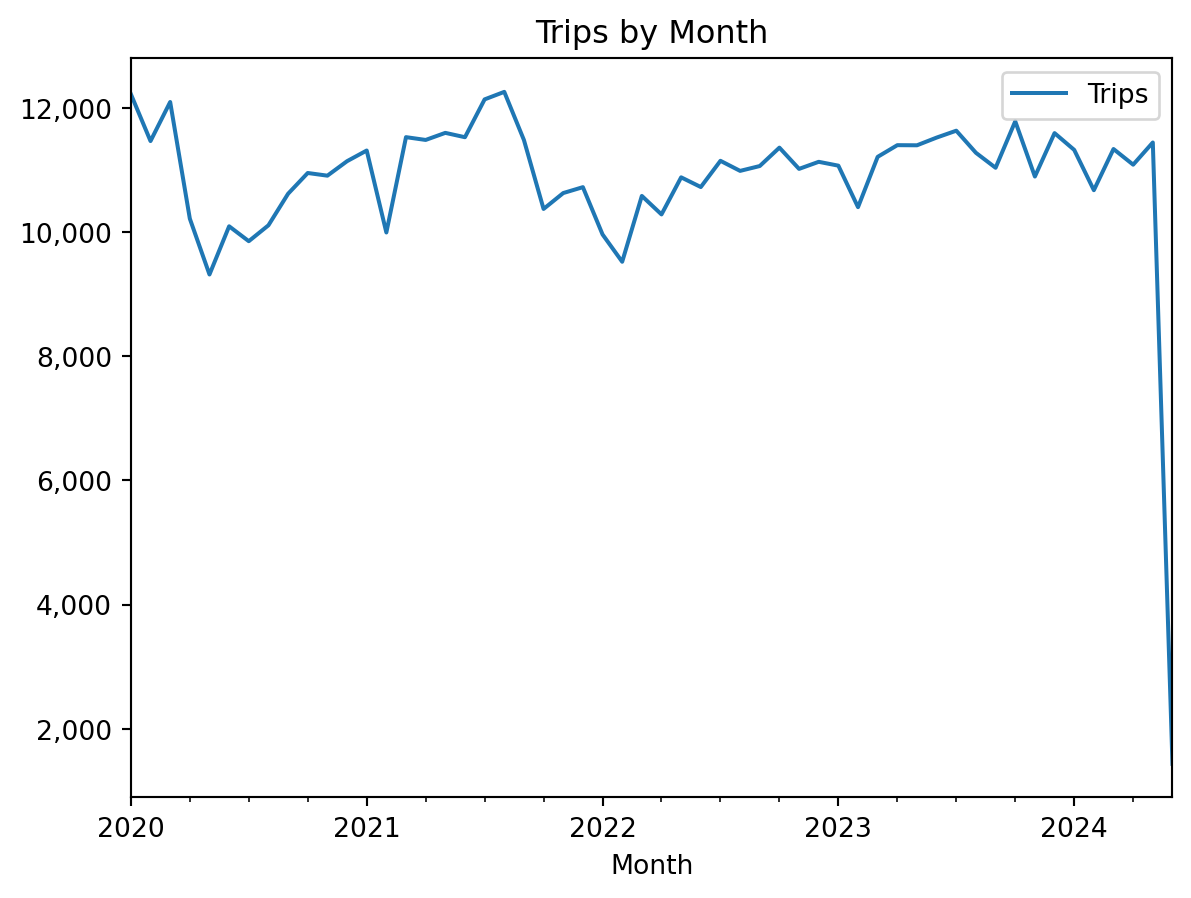

In [58]:
#| echo: false
import matplotlib.pyplot as plt
import matplotlib as mpl

ax = (
    vessel_history_validated
    .with_columns(
        pl.col("Date").dt.date().dt.month_start().alias("Month"),
    )
    .group_by("Month")
    .agg(pl.col("Vessel").count().alias("Trips"))
    .sort("Month")
    .to_pandas()
    .plot(
        x="Month",
        y="Trips",
        title="Trips by Month",
    )
)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

**Vessel Verbose**

- `{python} f"{vessel_verbose_validated.shape[0]:,}"` rows
- `{python} f"{vessel_verbose_validated.shape[1]:,}"` columns
- Vessels: `{python} ", ".join(vessel_verbose_validated['VesselName'].unique())`

## Task 7 - publish notebook as Quarto document to Posit Connect

### 🔄 Task

### 🧑‍💻 Code